# Chapter 4 - Regression and Prediction 
## Cont. Testing the Assumptions: Regression Diagnostics

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.gofplots import ProbPlot

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

from dmba import stepwise_selection
from dmba import AIC_score

In [3]:
url2= ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/house_sales.csv')

house = pd.read_csv(url2, sep='\t')

subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']

house[subset].head()

,AdjSalePrice,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade
1,300805.0,2400,9373,3.00,6,7
2,1076162.0,3764,20156,3.75,4,10
3,761805.0,2060,26036,1.75,4,8
4,442065.0,3200,8618,3.75,5,7
5,297065.0,1720,8620,1.75,4,7


# Outliers

You can detect outliers by examining the standardized residual, which is the residual
divided by the standard error of the residuals. Standardizedresiduals can be interpreted as “the number of standard errors away from the regression line.”

In [6]:
# Filter the house DataFrame to only include rows where the ZipCode is 98105
house_98105 = house.loc[house['ZipCode'] == 98105, ]

# Define the predictors (independent variables) and the outcome (dependent variable)
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade'] 
outcome = 'AdjSalePrice'                                                         

# Create an Ordinary Least Squares (OLS) model using the filtered data
house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))  # Assign a constant term (intercept) to the model

# Fit the model and store the results
result_98105 = house_outlier.fit()  # Fit the OLS model to estimate the coefficients

# Print the summary of the regression results
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          1.69e-103
Time:                        10:28:25   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

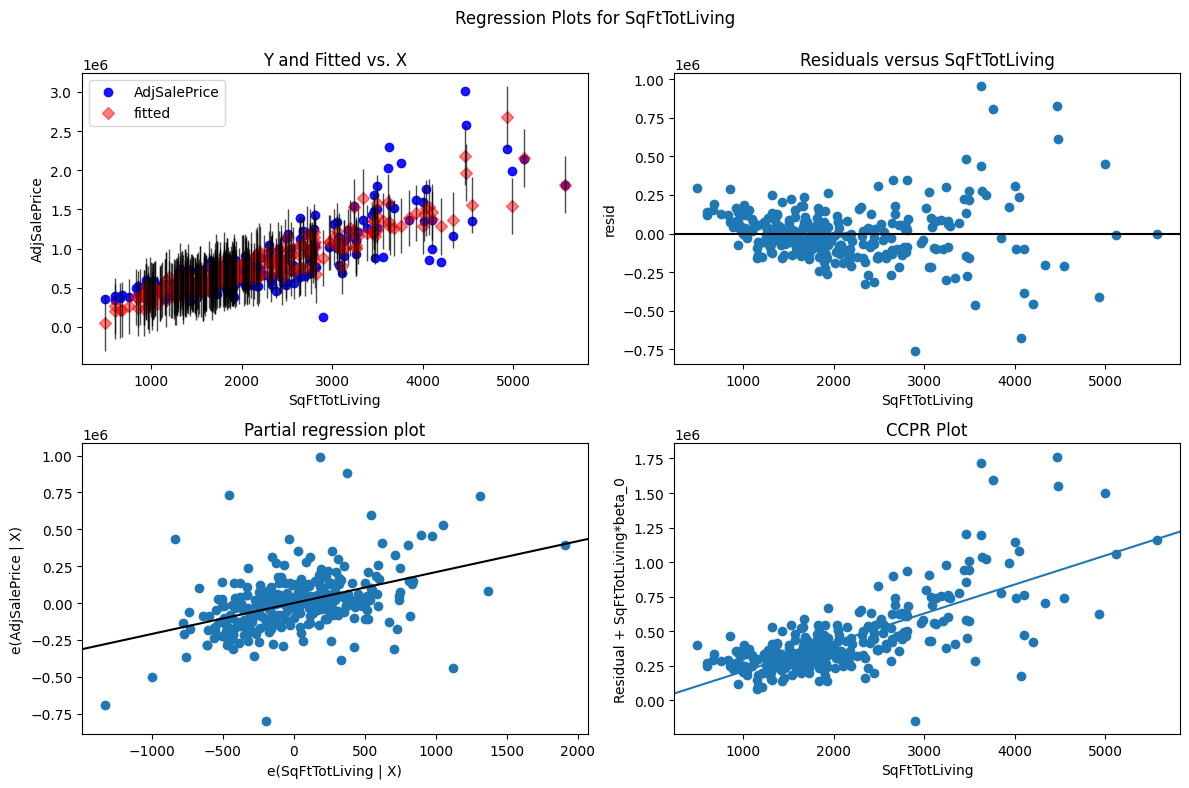


95% Prediction Intervals:
[[647854.37410606 705997.27581021]]


In [7]:
# Define predictors and outcome
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

# Add a constant to the predictor DataFrame for the intercept term
X = house_98105[predictors].assign(const=1)

# Define the outcome variable
y = house_98105[outcome]

# Create the OLS regression model and fit it
model = sm.OLS(y, X).fit()

# Produce diagnostic plots for the first predictor, 'SqFtTotLiving'
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(model, 'SqFtTotLiving', fig=fig)
plt.show()

# Create a new data frame for prediction (e.g., predict for specific values of predictors)
new_data = pd.DataFrame({'SqFtTotLiving': [2000], 'SqFtLot': [5000], 'Bathrooms': [2], 'Bedrooms': [3], 'BldgGrade': [7], 'const': 1})

# Make predictions using the fitted model
prediction = model.get_prediction(new_data)

# Extract prediction intervals with 95% confidence
prediction_intervals = prediction.conf_int(alpha=0.05)

# Print the results
print("\n95% Prediction Intervals:")
print(prediction_intervals)

#### 1. Y and Fitted vs. X

* The plot shows the actual values (`AdjSalePrice`) versus the fitted values from the model (`SqFtTotLiving`). There seems to be a strong positive trend between the living area size (SqFtTotLiving) and the adjusted sale price. 
*The spread of data points suggests a relatively good fit, but there are some deviations, particularly at higher `SqFtTotLiving` values, indicating the presence of outliers or increased variance.

#### 2. Residuals versus SqFtTotLiving

* The residuals appear to be randomly distributed around zero, which is a good indicator that there is no obvious non-linearity or pattern missed by the model.
* However, there are a few noticeable points with larger residuals, indicating potential outliers or influential points that might affect the model’s accuracy. 
* The spread appears consistent, although with a slightly wider variance for higher fitted values, suggesting **possible heteroscedasticity**.

#### 3. Partial Regression Plot

* The partial regression plot shows the relationship between the outcome (`AdjSalePrice`) and `SqFtTotLiving`, adjusting for the effects of other predictors.
* The positive trend in the plot indicates that `SqFtTotLiving` has a positive effect on `AdjSalePrice` after accounting for the other variables.
* However, there is still a fair amount of scatter, indicating that while `SqFtTotLiving` is significant, other factors also play a role in determining `AdjSalePrice`.
#### 4. CCPR (Component and Component Plus Residual) Plot

* The CCPR plot helps in understanding the relationship between `SqFtTotLiving` and `AdjSalePrice` while considering the influence of other variables.
* There is a clear upward trend, suggesting a positive association between `SqFtTotLiving` and `AdjSalePrice`.
* Similar to the other plots, a few outlier points exist, which may need further investigation or potentially influence the regression.

#### Conclusion:

`Model Fit`: The positive relationship between `SqFtTotLiving` and `AdjSalePrice` is evident in all the plots, indicating that `SqFtTotLiving` is an important predictor.

`Potential Issues`: There are some influential outliers and increased variance at higher values of `SqFtTotLiving`, which may indicate heteroscedasticity.

`Next Steps`: It would be beneficial to investigate and potentially handle the outliers and assess the model for heteroscedasticity more formally (e.g., using a Breusch-Pagan test). Additionally, transforming the variables or using a different model might help to address the variance issues observed at higher fitted values.

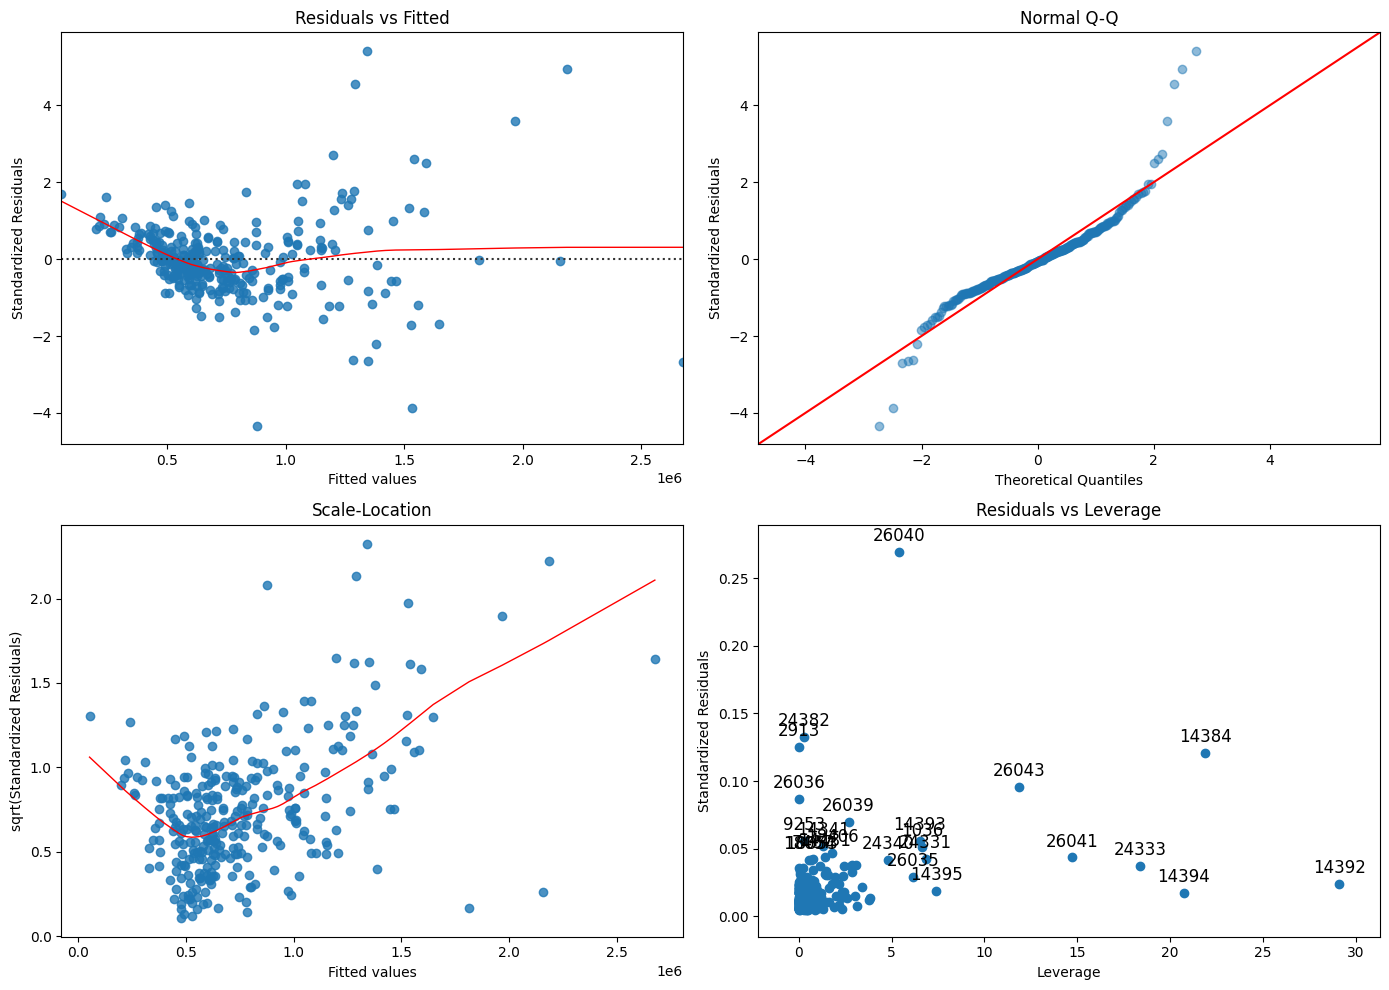

In [9]:
# Compute standardized residuals manually
standardized_residuals = model.get_influence().resid_studentized_internal

# Create ProbPlot object for the standardized residuals
QQ_residuals = ProbPlot(standardized_residuals)

# Create diagnostic plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs. Fitted Values Plot
sns.residplot(x=model.fittedvalues, y=standardized_residuals, lowess=True, ax=ax[0, 0], line_kws={'color': 'red', 'lw': 1})
ax[0, 0].set_title('Residuals vs Fitted')
ax[0, 0].set_xlabel('Fitted values')
ax[0, 0].set_ylabel('Standardized Residuals')

# Normal Q-Q Plot of Standardized Residuals
QQ_residuals.qqplot(line='45', alpha=0.5, lw=1, ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')
ax[0, 1].set_xlabel('Theoretical Quantiles')
ax[0, 1].set_ylabel('Standardized Residuals')

# Scale-Location Plot
sns.regplot(x=model.fittedvalues, y=np.sqrt(np.abs(standardized_residuals)), lowess=True, ax=ax[1, 0], line_kws={'color': 'red', 'lw': 1})
ax[1, 0].set_title('Scale-Location')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('sqrt(Standardized Residuals)')

# Residuals vs. Leverage Plot
sm.graphics.plot_leverage_resid2(model, ax=ax[1, 1])
ax[1, 1].set_title('Residuals vs Leverage')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Standardized Residuals')

plt.tight_layout()
plt.show()

#### 1. Residuals vs Fitted Plot
* This plot shows the standardized residuals against the fitted values.
* There is a distinct pattern where the residuals form a non-linear shape, indicating that the model may have a systematic error. This suggests the presence of **non-linearity**, which the model isn't capturing well.
* Additionally, there is some fan shape in the residuals, with increasing variance at higher fitted values, indicating potential heteroscedasticity. The spread of residuals increases as the fitted values increase, which could mean that the variance of the errors is not constant.
#### 2. Normal Q-Q Plot
* The Q-Q plot compares the distribution of the standardized residuals to a normal distribution.
* The points deviate significantly from the red line, especially in the tails, indicating that the residuals are not normally distributed. This suggests issues with the assumption of normality, particularly for the extreme values (both high and low).
* The deviations in the tails (with some residuals far above and below the line) indicate heavy-tailed distributions or the presence of outliers that are affecting the normality assumption.
#### 3. Scale-Location Plot (Spread-Location Plot)
* The Scale-Location plot (sqrt(Standardized Residuals) vs Fitted values) indicates whether the residuals spread equally along the range of predictors.
* There is a clear curvature in the red line, which is another sign of non-linearity in the model, and the increasing trend suggests heteroscedasticity—the variance of residuals increases with the fitted values.
* This plot supports the conclusion that the model might benefit from a transformation of the response variable or predictors to stabilize the variance.
#### 4. Residuals vs Leverage Plot
* The Residuals vs Leverage plot identifies influential points in the dataset.
* Several points (e.g., labeled 26040, 26039, etc.) appear to have high leverage, which means they could have a significant influence on the model's fit.
* One or two points, particularly at the top left, seem to combine **high residuals and high leverage**, which suggests they are **influential points**. These points may disproportionately impact the model's parameters and potentially reduce the model's overall reliability.
#### Conclusion:
##### Model Issues:

* The non-linearity evident in the residuals vs fitted and scale-location plots suggests that the model is not fully capturing the relationship between the predictors and the outcome.
* The heteroscedasticity indicates that the variance of errors changes with the fitted values, violating the assumption of homoscedasticity.
* The non-normality of residuals (as seen in the Q-Q plot) suggests that transformations may be required to improve model assumptions.
* There are influential points with high leverage and residuals that may need careful handling, such as further investigation, removal, or separate modeling.
##### Next Steps:

* Transform the Variables: Apply transformations (e.g., logarithmic) to the outcome variable or some predictors to address non-linearity and heteroscedasticity.
* Investigate Influential Points: Analyze and potentially remove or adjust influential points identified in the Residuals vs Leverage plot to reduce their undue influence on the model.
* Consider a Different Model: Use a more flexible model, such as polynomial regression, generalized linear models, or non-linear models, to better capture the underlying relationship.

In [11]:
# Calculate influence measures for the model

# Create an OLSInfluence object to assess model influence
influence = OLSInfluence(result_98105) 

# Get studentized residuals to assess residual outliers
sresiduals = influence.resid_studentized_internal  

# Print the index and value of the minimum studentized residual (potential outlier)
print(sresiduals.idxmin(), sresiduals.min())  

24333 -4.326731804078565


`sresiduals.idxmin()` returns the index of the observation with the smallest studentized residual, indicating which data point has the most extreme negative studentized residual.

`sresiduals.min()` returns the minimum value of the studentized residuals, representing how extreme that residual is.

Tells you which observation has the most extreme studentized residual and how extreme it is.

In [13]:
# Print the residual value at the index of the minimum studentized residual
print(model.resid.loc[sresiduals.idxmin()])

-757753.6192115832


`model.resid.loc[sresiduals.idxmin()]` extracts the actual residual value at that particular index. Residuals are the difference between the observed and predicted values for each observation. This line prints the raw residual value of the observation identified as having the smallest studentized residual.

Gives you the raw residual value for that specific observation, which helps to understand the magnitude of the prediction error.

In [15]:
# Extract the row from house_98105 corresponding to the minimum studentized residual (potential outlier)
outlier = house_98105.loc[sresiduals.idxmin(), :] 

print('AdjSalePrice', outlier[outcome])  # Print the adjusted sale price for the identified outlier
print(outlier[predictors])               # Print the predictor values for the identified outlier to understand its features

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


# Influential values

In addition to standardized residuals, statisticians have developed several metrics to determine the influence of a single record on a regression. A common measure of leverage is the hat-value; values above 2 (P + 1) /n indicate a high-leverage data value.

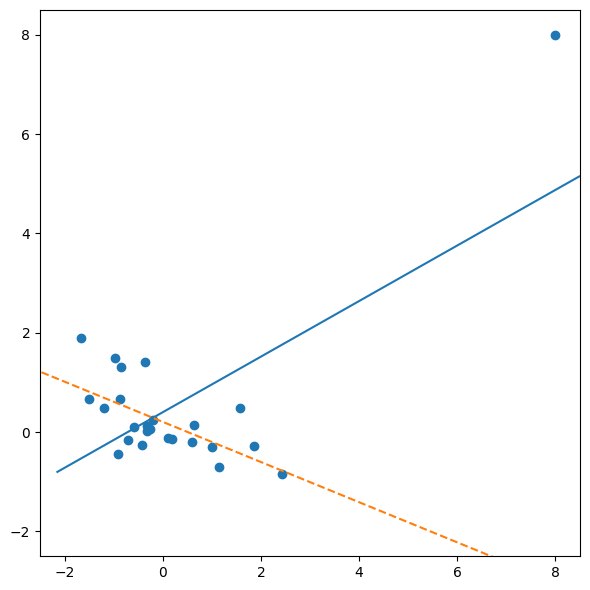

In [18]:
from scipy.stats import linregress 

np.random.seed(5)                       # Set the random seed for reproducibility
x = np.random.normal(size=25)           # Generate 25 random values from a normal distribution for x
y = -x / 5 + np.random.normal(size=25)  # Generate y values based on x with added noise, having a slight negative relationship
x[0] = 8  # Modify the first value of x to create an outlier
y[0] = 8  # Modify the first value of y to create an outlier corresponding to x[0]

# Define a function to calculate line coordinates based on slope and intercept
def abline(slope, intercept, ax):  
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())                  # Get the current x-axis limits of the plot
    return (x_vals, intercept + slope * x_vals)       # Return x values and corresponding y values for the line

fig, ax = plt.subplots(figsize=(6, 6))                # Create a figure and axis with size 4x4 inches
ax.scatter(x, y)                                      # Plot the scatter plot of x and y values

slope, intercept, _, _, _ = linregress(x, y)          # Perform linear regression on the entire dataset
ax.plot(*abline(slope, intercept, ax))                # Plot the regression line using all points

slope, intercept, _, _, _ = linregress(x[1:], y[1:])  # Perform linear regression excluding the first point (outlier)
ax.plot(*abline(slope, intercept, ax), '--')          # Plot the regression line without the outlier as a dashed line

ax.set_xlim(-2.5, 8.5)  # Set x-axis limits
ax.set_ylim(-2.5, 8.5)  # Set y-axis limits

plt.tight_layout()      # Adjust layout for better fit
plt.show()              # Display the plot

*An example of an influential data point in regression.*

Another metric is Cook’s distance, which defines influence as a combination of leverage and residual size. A rule of thumb is that an observation has high influence if
Cook’s distance exceeds 4/ n − P − 1 .

An influence plot or bubble plot combines standardized residuals, the hat-value, and
Cook’s distance in a single plot. 

A plot to determine which observations have high influence; points with Cook’s distance greater than 0.08 are considered highly influential.

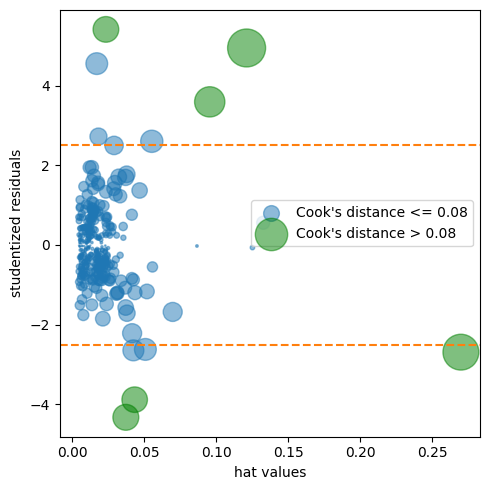

In [22]:
influence = OLSInfluence(result_98105)        # Create an OLSInfluence object to analyze influence diagnostics for the fitted OLS model

fig, ax = plt.subplots(figsize=(5, 5))        # Create a figure and axis with size 5x5 inches
ax.axhline(-2.5, linestyle='--', color='C1')  # Draw a horizontal dashed line at -2.5 to highlight extreme residual thresholds
ax.axhline(2.5, linestyle='--', color='C1')   # Draw a horizontal dashed line at 2.5 to highlight extreme residual thresholds

# Identify points with Cook's distance > 0.08
cooks_distance = influence.cooks_distance[0]
high_influence_points = cooks_distance > 0.08

# Scatter plot for points with Cook's distance <= 0.08
ax.scatter(influence.hat_matrix_diag[~high_influence_points], influence.resid_studentized_internal[~high_influence_points], 
           s=1000 * np.sqrt(cooks_distance[~high_influence_points]), alpha=0.5, label='Cook\'s distance <= 0.08')

# Scatter plot for points with Cook's distance > 0.08 (colored green)
ax.scatter(influence.hat_matrix_diag[high_influence_points], influence.resid_studentized_internal[high_influence_points], 
           s=1000 * np.sqrt(cooks_distance[high_influence_points]), alpha=0.5, color='green', label='Cook\'s distance > 0.08')

ax.set_xlabel('hat values')             # Set label for the x-axis (hat values represent leverage)
ax.set_ylabel('studentized residuals')  # Set label for the y-axis (studentized residuals to identify outliers)
ax.legend(loc='center right')           # Add a legend to differentiate the points based on Cook's distance

plt.tight_layout()  # Adjust layout to ensure proper fit of all elements
plt.show()          # Display the plot

There are apparently several data points that exhibit large influence in the regression.
Cook’s distance can be computed using the function cooks.distance, and you can
use hatvalues to compute the diagnostics. The hat values are plotted on the x-axis,
the residuals are plotted on the y-axis, and the size of the points is related to the value
of Cook’s distance.

In [24]:
# Create a boolean mask to filter out rows where Cook's distance is less than 0.08 (non-influential points)
mask = [dist < .08 for dist in influence.cooks_distance[0]] 

# Apply the mask to filter the house_98105 DataFrame, retaining only non-influential observations
house_infl = house_98105.loc[mask]  

# Create an OLS model using only the non-influential data points
ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))

# Fit the OLS model to the filtered dataset
result_infl = ols_infl.fit()  

# Create a DataFrame to compare the original model parameters with those obtained after removing influential points
pd.DataFrame({  
    'Original': result_98105.params,            # Parameters from the original model
    'Influential removed': result_infl.params,  # Parameters from the model with influential points removed
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


**Original:** This column shows the regression coefficients for the model fit to all data points, including influential points.

**Influential Removed:** This column shows the regression coefficients after removing influential points (observations with Cook's distance greater than 0.08).

# Heteroskedasticity, Non-Normality and Correlated Errors

**Heteroskedasticity** is the lack of constant residual variance across the range of the predicted values. In other words, errors are greater for some portions of the range than for others. Visualizing the data is a convenient way to analyze residuals.

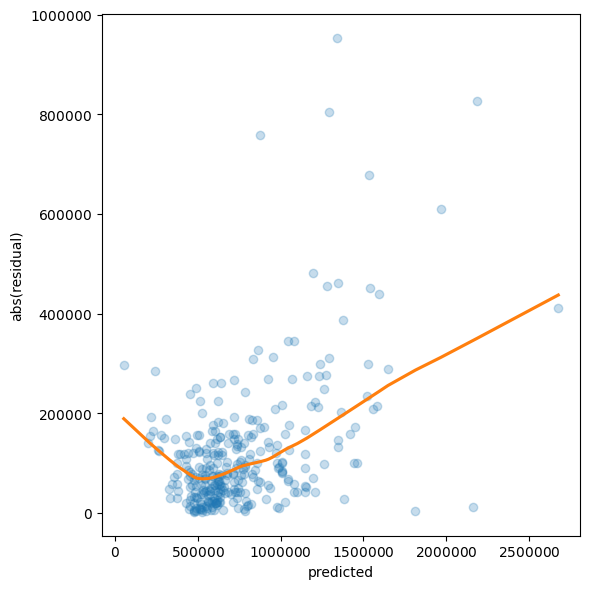

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis with size 6x6 inches for the plot

sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),  # Plot the fitted values vs absolute residuals using seaborn's regplot
            scatter_kws={'alpha': 0.25},                                # Set scatter plot transparency to 25% to reduce overlap visibility
            line_kws={'color': 'C1'},     # Set the color of the regression line to 'C1' (a predefined color from the color cycle)
            lowess=True, ax=ax)           # Use locally weighted regression (lowess) to fit a smooth line to the data

ax.set_xlabel('predicted')                # Set the x-axis label to 'predicted' (represents the fitted values from the model)
ax.set_ylabel('abs(residual)')            # Set the y-axis label to 'abs(residual)' (represents the absolute residuals)

ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use ScalarFormatter to format the x-axis labels normally
ax.ticklabel_format(style='plain', axis='x')                     # Ensure plain formatting for x-axis labels (no scientific notation)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use ScalarFormatter to format the y-axis labels normally
ax.ticklabel_format(style='plain', axis='y')                     # Ensure plain formatting for y-axis labels (no scientific notation)

plt.tight_layout()                        # Adjust layout to ensure that labels and elements are properly fitted in the figure
plt.show()                                # Display the plot

*A plot of the absolute value of the residuals versus the predicted values.*

Evidently, the variance of the residuals tends to increase for higher-valued homes but
is also large for lower-valued homes. This plot indicates that lm_98105 has **heteroskedastic errors**.

#### Why Would a Data Scientist Care About Heteroskedasticity?
Heteroskedasticity indicates that prediction errors differ for different ranges of the predicted value, and may suggest an incomplete
model. For example, the heteroskedasticity in lm_98105 may indicate that the regression has left something unaccounted for in highand low-range homes.

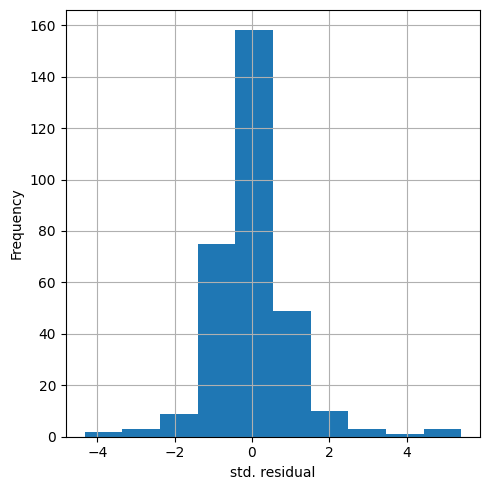

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))  # Create a figure and axis

pd.Series(influence.resid_studentized_internal).hist(ax=ax)  # Plot a histogram of the studentized residuals

ax.set_xlabel('std. residual')          # Set the label for the x-axis
ax.set_ylabel('Frequency')              # Set the label for the y-axis

plt.tight_layout()                      # Adjust layout
plt.show()                              # Display the histogram plot

*A histogram of the residuals from the regression of the housing data*

Statisticians may also check the assumption that the errors are independent. This is particularly true for data that is collected over time or space. The Durbin-Watson statistic can be used to detect if there is significant autocorrelation in a regression involving time series data. If the errors from a regression model are correlated, then this information can be useful in making short-term forecasts and should be built
into the model. 

# Partial Residual Plots and Nonlinearity

Partial residual plots are a way to visualize how well the estimated fit explains the relationship between a predictor and the outcome. The basic idea of a partial residual plot is to isolate the relationship between a predictor variable and the response, taking into account all of the other predictor variables.

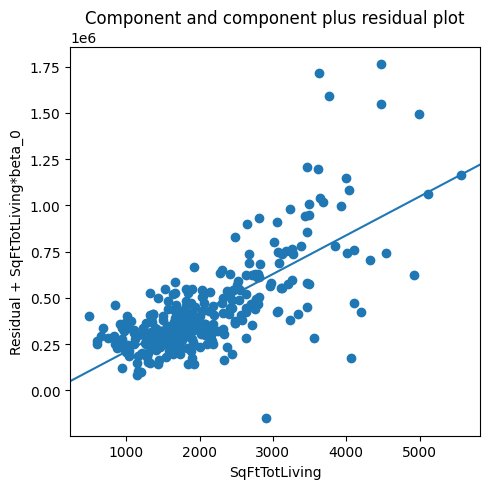

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))  # Create a 5x5 inch figure and axis

fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)  # Plot CCPR for 'SqFtTotLiving'

plt.tight_layout()  # Adjust layout
plt.show()          # Show the plot

*The partial residual is an estimate of the contribution that SqFtTotLiving adds to the sales price.*

This nonlinearity makes sense in this case: adding 500 feet in a small home makes a much bigger difference than adding 500 feet in a large home. This suggests that, instead of a simple linear term for SqFtTotLiving, a nonlinear term should be considered 

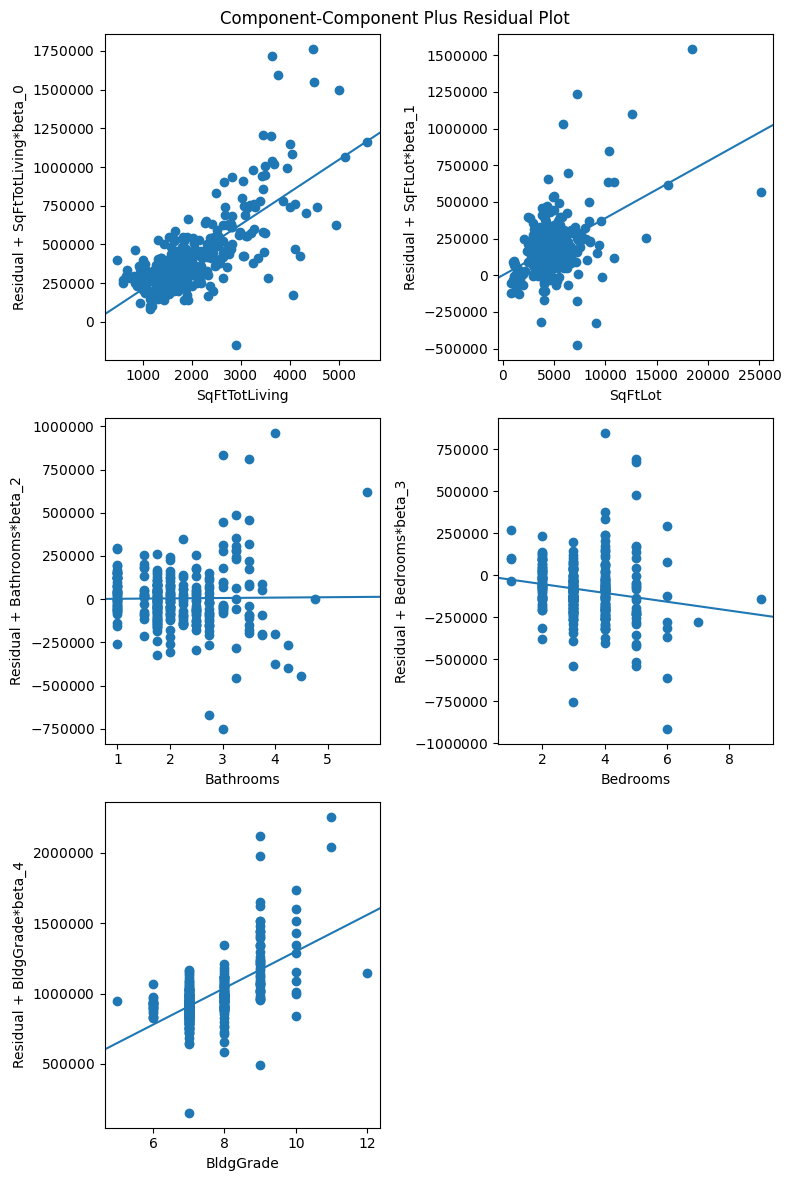

In [40]:
fig = plt.figure(figsize=(8, 12))                        # Create an 8x12 inch figure
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)  # Plot CCPR grid for all predictors

# Iterate through all axes in the figure to set y-axis labels to plain formatting
for ax in fig.axes:
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use ScalarFormatter for normal format
    ax.ticklabel_format(style='plain', axis='y')                     # Set y-axis to plain formatting (no scientific notation)

plt.tight_layout()  # Adjust layout to ensure proper fit
plt.show()          # Display the plot

The five graphs presented are Component-Component Plus Residual (CCPR) plots for each of the predictors in our model.

The y-axis values are of the form:

$$Residual + X_i \cdot \beta_i$$

For Top-Left Plot: SqFtTotLiving:

* X-axis: The size of the living area (SqFtTotLiving).
* Y-axis: Residual + SqFtTotLiving * beta_0.
* Interpretation: This graph shows the adjusted relationship between living area size and the adjusted sale price. There is an upward trend, indicating that as SqFtTotLiving increases, the adjusted sale price generally also increases, after controlling for the effects of the other variables.

# Polynomial and Spline Regression

This means the model includes both the linear and squared terms for SqFtTotLiving.

$AdjSalePrice = \beta_0 + \beta_1 \cdot SqFtTotLiving + \beta_2 \cdot (SqFtTotLiving)^2 + \beta_3 \cdot SqFtLot + \beta_4 \cdot Bathrooms + \beta_5 \cdot Bedrooms + \beta_6 \cdot BldgGrade + \epsilon$


In [44]:
# Define a polynomial regression model including a squared term for SqFtTotLiving
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                     'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)  

result_poly = model_poly.fit()  # Fit the polynomial model to the data
print(result_poly.summary())    # Print the summary of the fitted model

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          9.95e-106
Time:                        10:28:29   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

$AdjSalePrice = -615,900 + 7.4521 \cdot SqFtTotLiving + 0.0388\cdot (SqFtTotLiving)^2 + 32.5594\cdot SqFtLot -1435.1231\cdot Bathrooms + -9191.9441\cdot Bedrooms + 135,700\cdot BldgGrade + \epsilon $ 

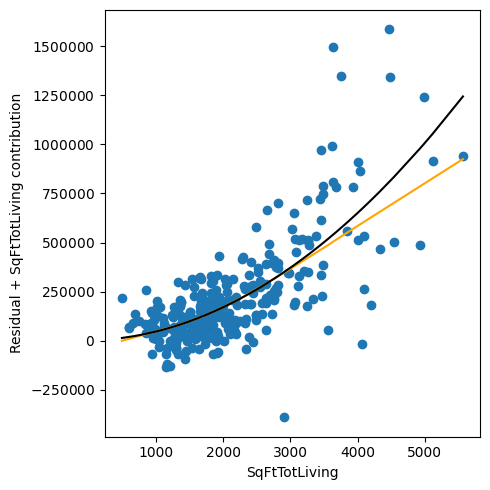

Value for beta_2: 0.03879128168236591


In [46]:
# Define function to plot partial residuals for a given feature
def partialResidualPlot(model, df, outcome, feature, ax): 
    
    y_pred = model.predict(df)                                   # Predict outcome using the model
    
    # Determine columns required for model
    required = set(model.params.index).intersection(df.columns)  # Get required columns used in the model
    required.add(feature)                                        # Add the feature of interest
    copy_df = df[list(required)].copy().astype('float')          # Create a copy of required columns as float type

    for c in copy_df.columns:                                    # Set all columns except the feature to zero
        if c == feature:
            continue
        copy_df.loc[:, c] = 0.0
    
    feature_prediction = model.predict(copy_df)                  # Predict outcome using only the feature contribution

    results = pd.DataFrame({                                     # Create DataFrame for plotting
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params.iloc[0],  # Partial prediction contribution of the feature
    })
    results = results.sort_values(by=['feature'])               # Sort by feature for smoother plotting
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)  # Fit a smoothed line using LOWESS

    ax.scatter(results.feature, results.ypartial + results.residual)                 # Scatter plot of partial residuals
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='orange')     # Plot smoothed trend line
    ax.plot(results.feature, results.ypartial, color='black')   # Plot partial regression line for feature contribution
    ax.set_xlabel(feature)                                      # Set x-axis label
    ax.set_ylabel(f'Residual + {feature} contribution')         # Set y-axis label

    # Ensure y-axis is not in scientific notation
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use ScalarFormatter to format y-axis labels normally
    ax.ticklabel_format(style='plain', axis='y')                     # Ensure y-axis labels are in plain formatting (no scientific notation)
    
    return ax                                                   # Return the axis with the plot

fig, ax = plt.subplots(figsize=(5, 5))                                              # Create a 5x5 inch figure and axis
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)  # Plot partial residuals for 'SqFtTotLiving'

plt.tight_layout()                 # Adjust layout for better fit
plt.show()                         # Display the plot
print("Value for beta_2:",result_poly.params.iloc[2])  # Print the parameter value for the second term (squared term in polynomial)

*A polynomial regression fit for the variable SqFtTotLiving (black line) versus a smooth (orange line).*

# Splines

B-spline transformation is a flexible mathematical function used to better capture curved relationships between variables. B-splines allow us to model this non-linearity in a way that captures changes in the slope without overfitting.

In [50]:
from patsy import bs  # Import 'bs' for B-spline transformations

# Define the model formula with a B-spline term for SqFtTotLiving (degree 3 and 6 basis functions)
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

model_spline = smf.ols(formula=formula, data=house_98105)  # Create an OLS model using the spline basis for SqFtTotLiving
result_spline = model_spline.fit()                         # Fit the model with spline features
print(result_spline.summary())                             # Print the summary of the fitted model

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          7.10e-104
Time:                        10:28:30   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


#### Explanation: bs(SqFtTotLiving, df=6, degree=3):

`bs` stands for B-spline, which is a type of basis function used to represent curved relationships in data.

`df=6`: The degrees of freedom (6) tells us how many different parts or "knots" we want to use for the curve. More parts allow for a more complex and flexible curve.

`degree=3`: The degree of the spline is set to 3, meaning it uses a cubic spline. This means each segment is a cubic polynomial, making the resulting curve smooth.

The B-spline transformation is used to allow the model to fit complex, non-linear relationships between SqFtTotLiving and AdjSalePrice.
The other predictors (SqFtLot, Bathrooms, Bedrooms, BldgGrade) are added linearly, assuming their relationship with price is more straightforward.

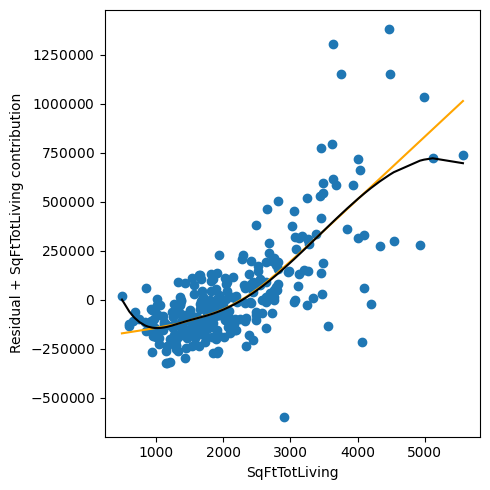

In [52]:
fig, ax = plt.subplots(figsize=(5, 5))  # Create a 5x5 inch figure and axis for plotting

partialResidualPlot(result_spline,      # Plot partial residuals using the spline model
                    house_98105,        # Data used for the model
                    'AdjSalePrice',     # Outcome variable
                    'SqFtTotLiving',    # Feature to plot partial residual for
                    ax)                 # Axis to plot on

plt.tight_layout()                      # Adjust layout for better fit
plt.show()                              # Display the plot

*A spline regression fit for the variable SqFtTotLiving (black line) compared to a smooth (orange line)*

# Generalized Additive Models
Suppose you suspect a nonlinear relationship between the response and a predictorvariable, either by a priori knowledge or by examining the regression diagnostics.Polynomial terms may not be flexible enough to capture the relationship, and splineterms require specifying the knots. Generalized additive models, or GAM, are a flexible modeling technique that can be used to automatically fit a spline regression. 

### Using statsmodels

In [55]:
from statsmodels.gam.api import GLMGam, BSplines  # Import GLMGam and BSplines for Generalized Additive Models

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']  # Define predictor variables
outcome = 'AdjSalePrice'                                                         # Define the outcome variable

x_spline = house_98105[predictors]                                # Extract the predictor data
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)  # Create B-splines for each predictor with specific degrees of freedom

# Penalization weight (alpha is used to penalize smoothness to avoid overfitting)
alpha = np.array([0] * 5)  # Set alpha to zero for no penalization

formula = ('AdjSalePrice ~ SqFtTotLiving + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')          # Define the model formula

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)  # Create Generalized Additive Model using the B-spline smoother
res_sm = gam_sm.fit()    # Fit the GAM model
print(res_sm.summary())  # Print the summary of the fitted GAM model

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                   295.00
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               Identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Thu, 28 Nov 2024   Deviance:                   8.1039e+12
Time:                        10:28:31   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

The model equation for `AdjSalePrice` can be expressed as follows:

$$
\begin{aligned}
AdjSalePrice = & \ \beta_0 + \beta_1 \cdot SqFtTotLiving + \beta_2 \cdot SqFtLot + \beta_3 \cdot Bathrooms + \beta_4 \cdot Bedrooms + \beta_5 \cdot BldgGrade \\
& + \sum_{i=0}^{7} \gamma_i \cdot SqFtTotLiving_{si} + \sum_{j=0}^{1} \delta_j \cdot SqFtLot_{sj} \\
& + \sum_{k=0}^{1} \theta_k \cdot Bathrooms_{sk} + \sum_{m=0}^{1} \eta_m \cdot Bedrooms_{sm} + \sum_{n=0}^{1} \xi_n \cdot BldgGrade_{sn} + \epsilon
\end{aligned}
$$

### Explanation:
- **Linear Terms**:
  - $\beta_0$: Intercept (constant term).
  - $\beta_1$, $\beta_2$, $\beta_3$, $\beta_4$, $\beta_5$: Linear coefficients for each predictor.
  
- **Spline Terms**:
  - The spline terms, such as \$\sum_{i=0}^{7} \gamma_i \cdot SqFtTotLiving_{si}\$, represent the non-linear contributions of the predictors using B-spline basis functions.
  - Each spline term captures the curvature in the relationship between the predictor and `AdjSalePrice`.

- **Error Term**:
  - $\epsilon$: The random error term, capturing deviations not explained by the model.


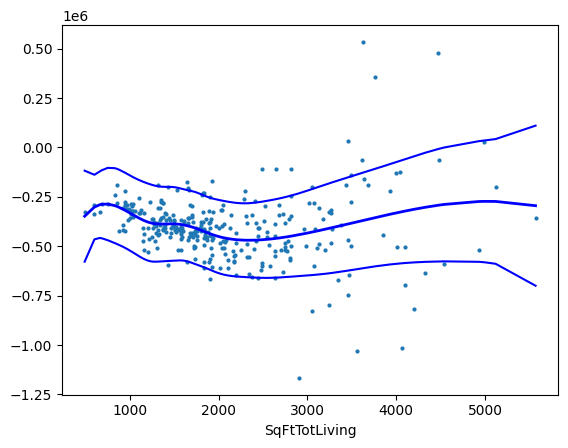

In [57]:
# Plot the partial residual plot (component plus residual) for the first predictor in the model
res_sm.plot_partial(0, cpr=True);

##### Non-Linear Trend:

The middle blue line is not a straight line, indicating a non-linear relationship between SqFtTotLiving and AdjSalePrice.
The trend shows some curvature, especially for the lower values of SqFtTotLiving, where it decreases initially before slightly leveling off and then increasing. This suggests that the effect of SqFtTotLiving on AdjSalePrice changes at different levels of square footage.

##### Impact of Living Area:

For smaller homes (up to around 1000-1500 sqft), the plot shows a slight negative contribution to the AdjSalePrice based on the trend. This could mean that adding more living space initially doesn't have a large positive impact on sale price or could even be detrimental due to other factors.
For moderate to large homes (2500-4000 sqft), the relationship appears more stable, with a nearly flat line in this range. This indicates that changes in SqFtTotLiving in this range may have a limited impact on AdjSalePrice.
For very large homes (above 4000 sqft), the slight upward trend suggests that additional square footage tends to increase the price, but this effect is more prominent in very large homes.

##### Scatter and Confidence Bands:

The scatter of points around the trend line shows the variability in AdjSalePrice for different values of SqFtTotLiving. The higher variability, especially at larger values of SqFtTotLiving, indicates that the price is influenced by other factors beyond just living area.
The confidence bands are wider at both ends (smaller and larger values of SqFtTotLiving), suggesting higher uncertainty in predicting the price for very small or very large homes. This could imply fewer data points in these ranges or more variability in the relationship.

### Using pyGAM

In [60]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']  # Define predictor variables
outcome = 'AdjSalePrice'                                                         # Define the outcome variable

X = house_98105[predictors].values  # Extract predictor values as a NumPy array
y = house_98105[outcome]            # Extract the outcome variable

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))  # Create a Generalized Additive Model (GAM) with a spline for the first predictor
gam.gridsearch(X, y)                                             # Perform grid search to optimize the model's hyperparameters
print(gam.summary())                                             # Print a summary of the fitted GAM model

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1718
                                                Scale:                                    29480381715.8332
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

C:\Users\lsoares\AppData\Local\Temp\ipykernel_40132\2463999776.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())                                             # Print a summary of the fitted GAM model


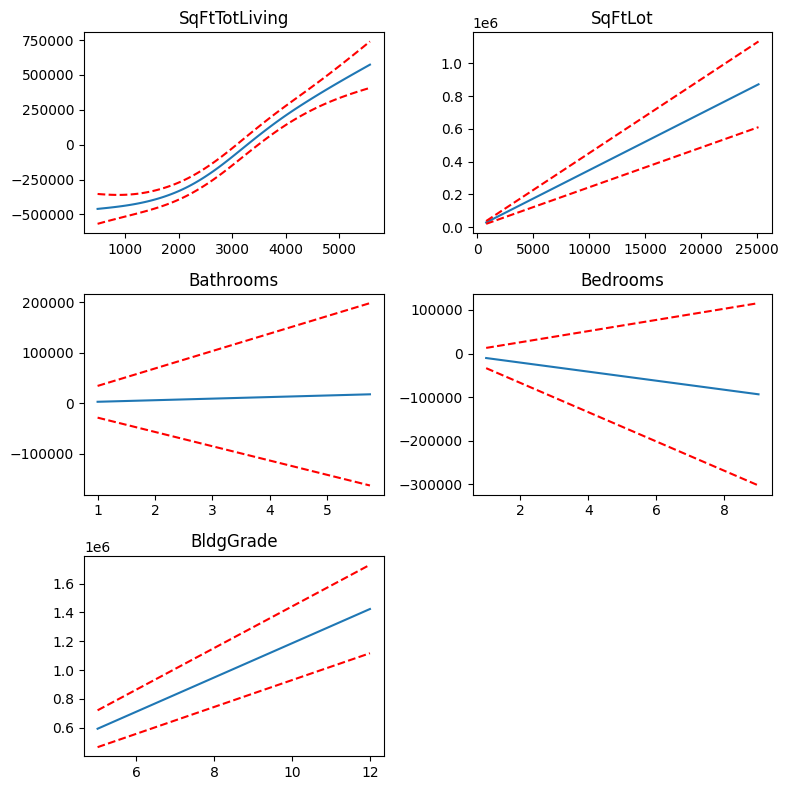

In [61]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)  # Create a figure with 6 subplots arranged in 2 columns and 3 rows

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']  # Define titles for each subplot (representing predictors)

for i, title in enumerate(titles):                                                         # Loop through each predictor and its corresponding title
    ax = axes[i // 2, i % 2]                                                               # Select the correct axis for the subplot
    XX = gam.generate_X_grid(term=i)                                                       # Generate grid values for the i-th term for plotting
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))                                # Plot partial dependence for the i-th predictor
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')  # Plot the 95% confidence interval with a dashed red line
    ax.set_title(titles[i])                                                                # Set the title for each subplot with the predictor name
    
axes[2][1].set_visible(False)  # Hide the unused subplot in the bottom right corner

plt.tight_layout()             # Adjust layout to avoid overlapping labels and ensure proper spacing
plt.show()                     # Display the plot

# Additional material - not in book
## Regularization
### Lasso